In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from torch.utils.data import Dataset

base_train_dataset = datasets.STL10(root="./", split="train", download=True)
base_test_dataset  = datasets.STL10(root="./", split="test", download=True)

cnn_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15)
])

def vit_train_transform(img):
    img = train_augment(img)   # apply torchvision augmentations
    return processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)

def vit_test_transform(img):
    return processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)

class TransformDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.base_dataset)

cnn_train_data = TransformDataset(base_train_dataset, cnn_transform)
cnn_test_data  = TransformDataset(base_test_dataset, cnn_transform)

vit_train_data = TransformDataset(base_train_dataset, vit_train_transform)
vit_test_data  = TransformDataset(base_test_dataset, vit_test_transform)

cnn_train_loader = DataLoader(cnn_train_data, batch_size=128, shuffle=True)
cnn_test_loader  = DataLoader(cnn_test_data, batch_size=128, shuffle=False)

vit_train_loader = DataLoader(vit_train_data, batch_size=128, shuffle=True)
vit_test_loader  = DataLoader(vit_test_data, batch_size=128, shuffle=False)


100%|██████████| 2.64G/2.64G [01:45<00:00, 25.0MB/s]


In [ ]:
!pip install transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image

cnn_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 10) #Replacing Last Layer to match STL's 10 classes

vit_model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-small-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)

processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

In [ ]:
from tqdm import tqdm

def get_logits(outputs):
    """Handle TorchVision (tensor) and HuggingFace (ImageClassifierOutput)."""
    return outputs.logits if hasattr(outputs, "logits") else outputs


def train_epoch(model, train_loader, loss_fn, optimizer, device="cuda"):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        logits = get_logits(outputs)              # ✅ safe extraction
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        # Accumulate properly
        batch_size = labels.size(0)
        train_loss += loss.item() * batch_size
        total += batch_size
        _, pred = logits.max(1)
        correct += pred.eq(labels).sum().item()

    avg_loss = train_loss / total
    acc = correct / total
    return avg_loss, acc


def test_epoch(model, test_loader, loss_fn, device="cuda"):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            logits = get_logits(outputs)          # ✅ safe extraction
            loss = loss_fn(logits, labels)

            batch_size = labels.size(0)
            test_loss += loss.item() * batch_size
            total += batch_size
            _, pred = logits.max(1)
            correct += pred.eq(labels).sum().item()

    avg_loss = test_loss / total
    acc = correct / total
    return avg_loss, acc


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


In [ ]:
loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.fc.parameters(), lr=1e-3)

epochs = 3

cnn_train_loss = []
cnn_train_acc = []
cnn_test_loss = []
cnn_test_acc = []

cnn_model = cnn_model.to(device)

for epoch in tqdm(range(epochs)):
  train_ep_loss, train_ep_acc = train_epoch(cnn_model, cnn_train_loader, loss_fn, cnn_optimizer)
  cnn_train_loss.append(train_ep_loss)
  cnn_train_acc.append(100.*train_ep_acc)
  test_ep_loss, test_ep_acc = test_epoch(cnn_model, cnn_test_loader, loss_fn)
  cnn_test_loss.append(test_ep_loss)
  cnn_test_acc.append(100.*test_ep_acc)

  print(f"""Epoch [{epoch+1}/{epochs}]
  Train Loss: {train_ep_loss:.4f} | Test Loss: {test_ep_loss:.4f}
  Train Accuracy: {(100.*train_ep_acc):.4f}% | Test Accuracy: {(100.*test_ep_acc):.4f}%""")

 33%|███▎      | 1/3 [01:34<03:08, 94.14s/it]

Epoch [1/3]
  Train Loss: 0.7892 | Test Loss: 0.2352
  Train Accuracy: 83.1800% | Test Accuracy: 95.5875%


 67%|██████▋   | 2/3 [03:12<01:36, 96.53s/it]

Epoch [2/3]
  Train Loss: 0.2055 | Test Loss: 0.1726
  Train Accuracy: 95.6000% | Test Accuracy: 95.7625%


100%|██████████| 3/3 [04:50<00:00, 96.99s/it]

Epoch [3/3]
  Train Loss: 0.1482 | Test Loss: 0.1426
  Train Accuracy: 96.6000% | Test Accuracy: 96.3625%


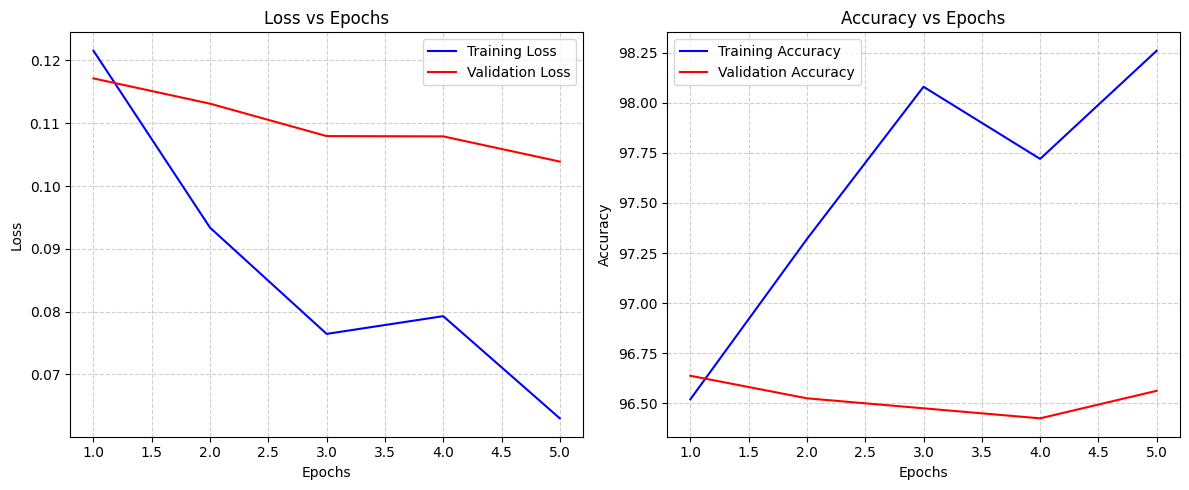

In [ ]:
plot_training_curves(cnn_train_loss, cnn_test_loss, cnn_train_acc, cnn_test_acc)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.AdamW([
    {"params": vit_model.vit.parameters(), "lr": 1e-4},
    {"params": vit_model.classifier.parameters(), "lr": 5e-4}
], weight_decay=0.05)

vit_train_loss = []
vit_train_acc = []
vit_test_loss = []
vit_test_acc = []

epochs = 3

vit_model.to(device)

for param in vit_model.vit.parameters():
    param.requires_grad = True

for epoch in tqdm(range(epochs)):
  train_ep_loss, train_ep_acc = train_epoch(vit_model, vit_train_loader, loss_fn, vit_optimizer)
  vit_train_loss.append(train_ep_loss)
  vit_train_acc.append(100.*train_ep_acc)
  test_ep_loss, test_ep_acc = test_epoch(vit_model, vit_test_loader, loss_fn)
  vit_test_loss.append(test_ep_loss)
  vit_test_acc.append(100.*test_ep_acc)

  print(f"""Epoch [{epoch+1}/{epochs}]
  Train Loss: {train_ep_loss:.4f} | Test Loss: {test_ep_loss:.4f}
  Train Accuracy: {(100.*train_ep_acc):.4f}% | Test Accuracy: {(100.*test_ep_acc):.4f}%""")

 33%|███▎      | 1/3 [02:42<05:24, 162.42s/it]

Epoch [1/3]
  Train Loss: 0.3406 | Test Loss: 0.0546
  Train Accuracy: 90.1800% | Test Accuracy: 98.2375%


 67%|██████▋   | 2/3 [05:16<02:37, 157.66s/it]

Epoch [2/3]
  Train Loss: 0.0587 | Test Loss: 0.0675
  Train Accuracy: 98.1200% | Test Accuracy: 97.8000%


100%|██████████| 3/3 [07:44<00:00, 154.68s/it]

Epoch [3/3]
  Train Loss: 0.0503 | Test Loss: 0.0486
  Train Accuracy: 98.3800% | Test Accuracy: 98.3500%


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
cnn_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 10)

vit_model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-small-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)

cnn_model.load_state_dict(torch.load("cnn_model.pth"))

vit_model.load_state_dict(torch.load("vit_model.pth"))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
#Baseline Inference
processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

cnn_test_imgs, cnn_test_labels = (next(iter(cnn_test_loader)))
cnn_test_imgs, cnn_test_labels = cnn_test_imgs.to(device), cnn_test_labels.to(device)
vit_test_imgs, vit_test_labels = (next(iter(vit_test_loader)))
vit_test_imgs, vit_test_labels = vit_test_imgs.to(device), vit_test_labels.to(device)


with torch.inference_mode():
  cnn_model.eval().to(device)
  vit_model.eval().to(device)
  cnn_outputs = cnn_model(cnn_test_imgs)
  vit_outputs = vit_model(vit_test_imgs)
  cnn_logits = get_logits(cnn_outputs)
  vit_logits = get_logits(vit_outputs)

  cnn_batch_size = cnn_test_labels.size(0)
  vit_batch_size = vit_test_labels.size(0)

  cnn_total = cnn_batch_size
  vit_total = vit_batch_size
  _, cnn_pred = cnn_logits.max(1)
  _, vit_pred = vit_logits.max(1)
  cnn_correct = cnn_pred.eq(cnn_test_labels).sum().item()
  vit_correct = vit_pred.eq(vit_test_labels).sum().item()
  cnn_acc = cnn_correct/cnn_total
  vit_acc = vit_correct/vit_total

print(f"CNN Accuracy: {(cnn_acc*100):.2f}%  |  Vit Accuracy: {(vit_acc*100):.2f}%")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

CNN Accuracy: 95.31%  |  Vit Accuracy: 97.66%


# Experiment 1: Testing Color Bias in CNNs vs VITs

In [ ]:
to_gray = transforms.Grayscale(num_output_channels=3)  # keep 3 channels for pretrained models
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # ImageNet mean
    std=[0.229, 0.224, 0.225]
)

def get_logits(outputs):
    """Handle TorchVision (tensor) and HuggingFace (ImageClassifierOutput)."""
    return outputs.logits if hasattr(outputs, "logits") else outputs

def eval_color_bias(model, loader, device="cuda"):
  model.eval()
  color_accs, gs_accs = [], []

  for i, (imgs, labels) in enumerate(loader):
    imgs, labels = imgs.to(device), labels.to(device)

    with torch.inference_mode():
      c_outputs = model(imgs)
    c_logits = get_logits(c_outputs)
    c_correct = (c_logits.argmax(1) == labels).sum().item()
    c_acc = c_correct / len(labels)
    color_accs.append(c_acc)

    gs_imgs = torch.stack([
        normalize(to_tensor(to_gray(to_pil(img.cpu()))))
        for img in imgs
    ]).to(device)

    with torch.inference_mode():
      gs_outputs = model(gs_imgs)
    gs_logits = get_logits(gs_outputs)
    gs_correct = (gs_logits.argmax(1) == labels).sum().item()
    gs_acc = gs_correct / len(labels)
    gs_accs.append(gs_acc)

  return color_accs, gs_accs

In [ ]:
cnn_color_accs = []
cnn_gs_accs = []
vit_color_accs = []
vit_gs_accs = []

cnn_color_accs, cnn_gs_accs = eval_color_bias(cnn_model, cnn_train_loader)
vit_color_accs, vit_gs_accs = eval_color_bias(vit_model, vit_train_loader)


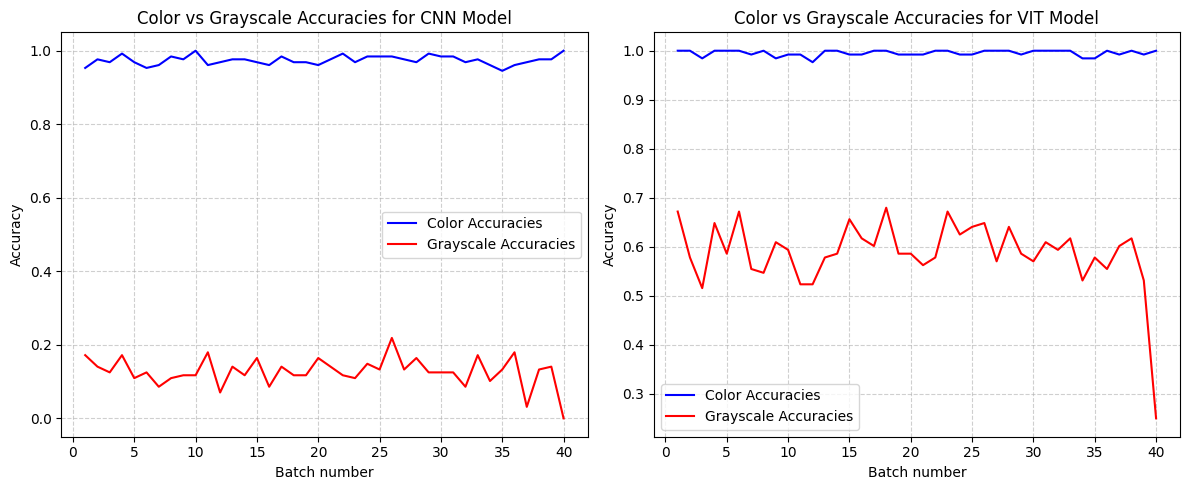


Average Accuracy Over Batches:
CNN Color: 97.40%  |  CNN Grayscale: 12.71%  | CNN Accuracy Drop : 84.69%
VIT Color: 99.53%  |  VIT Grayscale: 58.73%  | VIT Accuracy Drop : 40.80%


In [ ]:
batches = list(range(1, len(cnn_color_accs)+1))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(batches, cnn_color_accs, 'b-', label='Color Accuracies')
plt.plot(batches, cnn_gs_accs, 'r-', label='Grayscale Accuracies')
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.title("Color vs Grayscale Accuracies for CNN Model")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(batches, vit_color_accs, 'b-', label='Color Accuracies')
plt.plot(batches, vit_gs_accs, 'r-', label='Grayscale Accuracies')
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.title("Color vs Grayscale Accuracies for VIT Model")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

avg_cnn_color = sum(cnn_color_accs) / len(cnn_color_accs)
avg_cnn_gs = sum(cnn_gs_accs) / len(cnn_gs_accs)
avg_vit_color = sum(vit_color_accs) / len(vit_color_accs)
avg_vit_gs = sum(vit_gs_accs) / len(vit_gs_accs)

print(f"""
Average Accuracy Over Batches:
CNN Color: {((avg_cnn_color)*100):.2f}%  |  CNN Grayscale: {((avg_cnn_gs)*100):.2f}%  | CNN Accuracy Drop : {((avg_cnn_color-avg_cnn_gs)*100):.2f}%
VIT Color: {((avg_vit_color)*100):.2f}%  |  VIT Grayscale: {((avg_vit_gs)*100):.2f}%  | VIT Accuracy Drop : {((avg_vit_color-avg_vit_gs)*100):.2f}%""")

In [ ]:
torch.save(cnn_model.state_dict(), "cnn_model.pth")

from google.colab import files
files.download("cnn_model.pth")

torch.save(vit_model.state_dict(), "vit_model.pth")

from google.colab import files
files.download("vit_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Experiment 2: Testing Texture Bias in CNNs Vs ViTs

In [2]:
import os
import random
from pathlib import Path
from collections import defaultdict


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torchvision.models import resnet50
from PIL import Image


import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torchvision
from torchvision import datasets
from tqdm import tqdm


from transformers import ViTForImageClassification, ViTImageProcessor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [1]:
from google.colab import drive
drive.mount('/content/drive')

cnn_path = "/content/drive/MyDrive/Task1_models/cnn_model.pth"
vit_path = "/content/drive/MyDrive/Task1_models/vit_model.pth"

Mounted at /content/drive


In [ ]:
!pip install torch torchvision pillow matplotlib transformers datasets tqdm

In [4]:
!git clone https://github.com/naoto0804/pytorch-AdaIN.git
%cd pytorch-AdaIN

Cloning into 'pytorch-AdaIN'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 344 (delta 71), reused 60 (delta 60), pack-reused 264 (from 3)
Receiving objects: 100% (344/344), 7.80 MiB | 17.10 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/content/pytorch-AdaIN


In [ ]:
import sys
sys.path.append("pytorch-AdaIN")

from function import adaptive_instance_normalization
from net import decoder, vgg

In [5]:
# Instantiate models from AdaIN repo
from net import decoder, vgg

# Download pretrained weights (shell commands)
!wget -O decoder.pth "https://github.com/naoto0804/pytorch-AdaIN/releases/download/v0.0.0/decoder.pth"
!wget -O vgg_normalised.pth "https://github.com/naoto0804/pytorch-AdaIN/releases/download/v0.0.0/vgg_normalised.pth"

# Put models in eval mode
decoder.eval()
vgg.eval()

# Load weights
decoder.load_state_dict(torch.load("decoder.pth", map_location=device))
vgg.load_state_dict(torch.load("vgg_normalised.pth", map_location=device))

# Move to GPU/CPU
decoder = decoder.to(device)
vgg = vgg.to(device)

print("✅ AdaIN models loaded")


--2025-09-23 19:57:19--  https://github.com/naoto0804/pytorch-AdaIN/releases/download/v0.0.0/decoder.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/112338125/bf17fc1d-6b88-404c-9ec1-ecb143bd2d1f?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-23T20%3A47%3A20Z&rscd=attachment%3B+filename%3Ddecoder.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-23T19%3A46%3A44Z&ske=2025-09-23T20%3A47%3A20Z&sks=b&skv=2018-11-09&sig=voL3hsGtetgnzPyvH%2F9q6clzByS1DQ7t1XS84v9q%2FXY%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODY1Nzc0MCwibmJmIjoxNzU4NjU3NDQwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi

In [14]:
from function import adaptive_instance_normalization as adain

def stylize_image(content_img, style_img, alpha=0.0001):
    """Create stylized image using AdaIN"""
    with torch.no_grad():
        content_img, style_img = content_img.to(device), style_img.to(device)
        content_features, style_features = vgg(content_img), vgg(style_img)
        t = adain(content_features, style_features)
        t = alpha * t + (1 - alpha) * content_features
        output = decoder(t).cpu()
    return output

In [15]:
# Base transform (resize + to tensor)
base_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Normalization transforms
cnn_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

vit_processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

# Load STL-10 test set (raw, unnormalized — for stylization)
test_dataset_raw = STL10(root="./data", split="test", download=True, transform=base_transform)
print("STL-10 classes:", test_dataset_raw.classes)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

STL-10 classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [16]:
# Example mapping (cue conflict)
texture_mapping = {
    0: 1, 1: 2, 2: 3, 3: 4, 4: 5,
    5: 6, 6: 7, 7: 8, 8: 9, 9: 0
}

def generate_stylized_dataset(dataset, mapping, save_dir="stylized_test"):
    os.makedirs(save_dir, exist_ok=True)
    labels = []

    for idx, (content_img, label) in enumerate(dataset):
        mapped_class = mapping[label]
        style_candidates = [i for i, l in enumerate(dataset.labels) if l == mapped_class]
        style_idx = random.choice(style_candidates)
        style_img, _ = dataset[style_idx]

        content_img, style_img = content_img.unsqueeze(0), style_img.unsqueeze(0)
        out = stylize_image(content_img, style_img)

        out_img = transforms.ToPILImage()(out.squeeze().clamp(0,1))
        path = os.path.join(save_dir, f"{idx}.png")
        out_img.save(path)
        labels.append(label)

        if idx % 500 == 0:
            print(f"Processed {idx}/{len(dataset)} images")

    np.save(os.path.join(save_dir, "labels.npy"), np.array(labels))
    print("✅ Stylized dataset saved at", save_dir)
    return save_dir

#Generate only if not already present
# if not os.path.exists("stylized_test/labels.npy"):
generate_stylized_dataset(test_dataset_raw, texture_mapping, save_dir="stylized_test")
# else:
#     print("⚡ Using cached stylized dataset")

Processed 0/8000 images
Processed 500/8000 images
Processed 1000/8000 images
Processed 1500/8000 images
Processed 2000/8000 images
Processed 2500/8000 images
Processed 3000/8000 images
Processed 3500/8000 images
Processed 4000/8000 images
Processed 4500/8000 images
Processed 5000/8000 images
Processed 5500/8000 images
Processed 6000/8000 images
Processed 6500/8000 images
Processed 7000/8000 images
Processed 7500/8000 images
✅ Stylized dataset saved at stylized_test


'stylized_test'

In [17]:
from transformers import ViTImageProcessor, ViTForImageClassification
cnn_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 10)

vit_model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-small-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)

processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

cnn_model.load_state_dict(torch.load(cnn_path))

vit_model.load_state_dict(torch.load(vit_path))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

<All keys matched successfully>

In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from PIL import Image
import os
import numpy as np
import torch

# 🔹 CNN transform (normalize to ImageNet stats)
cnn_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# 🔹 For ViT: raw PIL only, processor will handle resize/norm
def collate_fn_pil(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

# -------------------------
# Stylized dataset class
# -------------------------
class StylizedSTL10(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.img_files = sorted([f for f in os.listdir(root) if f.endswith(".png")])
        self.labels = np.load(os.path.join(root, "labels.npy"))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

# -------------------------
# CNN datasets + loaders
# -------------------------
test_dataset_cnn = datasets.STL10(root="./data", split="test", download=True, transform=cnn_transform)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

stylized_dataset_cnn = StylizedSTL10(root="stylized_test", transform=cnn_transform)
stylized_loader_cnn = DataLoader(stylized_dataset_cnn, batch_size=64, shuffle=False, num_workers=2)

# -------------------------
# ViT datasets + loaders (PIL only, processor will transform)
# -------------------------
test_dataset_vit = datasets.STL10(root="./data", split="test", download=True, transform=None)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=64, shuffle=False, collate_fn=collate_fn_pil)

stylized_dataset_vit = StylizedSTL10(root="stylized_test", transform=None)
stylized_loader_vit = DataLoader(stylized_dataset_vit, batch_size=64, shuffle=False, num_workers=2, collate_fn=collate_fn_pil)


In [19]:
def evaluate_model(model, dataloader, device, desc="", is_vit=False, processor=None):
    model.eval()
    correct, total = 0, 0
    num_classes = 10
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(device)

            if is_vit:
                # images = list of PILs
                inputs = processor(images=images, return_tensors="pt").pixel_values.to(device)
                outputs = model(inputs).logits
            else:
                # CNN: already tensors
                images = images.to(device)
                outputs = model(images)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for i in range(len(labels)):
                class_total[labels[i].item()] += 1
                class_correct[labels[i].item()] += (preds[i] == labels[i]).item()

    acc = 100 * correct / total
    per_class_acc = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

    print(f"{desc} Accuracy: {acc:.2f}%")
    return acc, per_class_acc


In [20]:
cnn_model.to(device)
vit_model.to(device)

print("Evaluating CNN on original test set...")
cnn_acc_orig, cnn_per_class_orig = evaluate_model(cnn_model, test_loader_cnn, device, desc="CNN Original")

print("Evaluating CNN on stylized test set...")
cnn_acc_styl, cnn_per_class_styl = evaluate_model(cnn_model, stylized_loader_cnn, device, desc="CNN Stylized")

print("Evaluating ViT on original test set...")
vit_acc_orig, vit_per_class_orig = evaluate_model(vit_model, test_loader_vit, device, desc="ViT Original",
                                                  is_vit=True, processor=vit_processor)

print("Evaluating ViT on stylized test set...")
vit_acc_styl, vit_per_class_styl = evaluate_model(vit_model, stylized_loader_vit, device, desc="ViT Stylized",
                                                  is_vit=True, processor=vit_processor)

print("\nResults:")
print(f"CNN Original: {cnn_acc_orig:.3f}, CNN Stylized: {cnn_acc_styl:.3f}")
print(f"ViT Original: {vit_acc_orig:.3f}, ViT Stylized: {vit_acc_styl:.3f}")


Evaluating CNN on original test set...
CNN Original Accuracy: 96.36%
Evaluating CNN on stylized test set...
CNN Stylized Accuracy: 10.10%
Evaluating ViT on original test set...
ViT Original Accuracy: 98.35%
Evaluating ViT on stylized test set...
ViT Stylized Accuracy: 9.75%

Results:
CNN Original: 96.362, CNN Stylized: 10.100
ViT Original: 98.350, ViT Stylized: 9.750


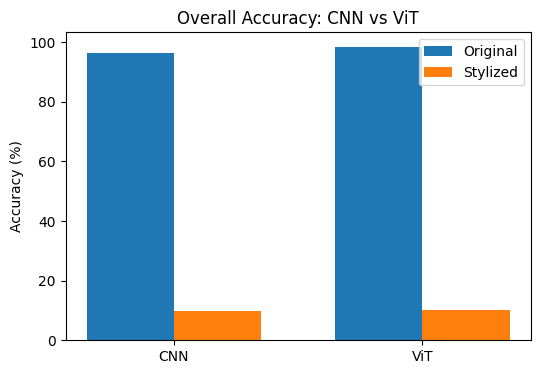

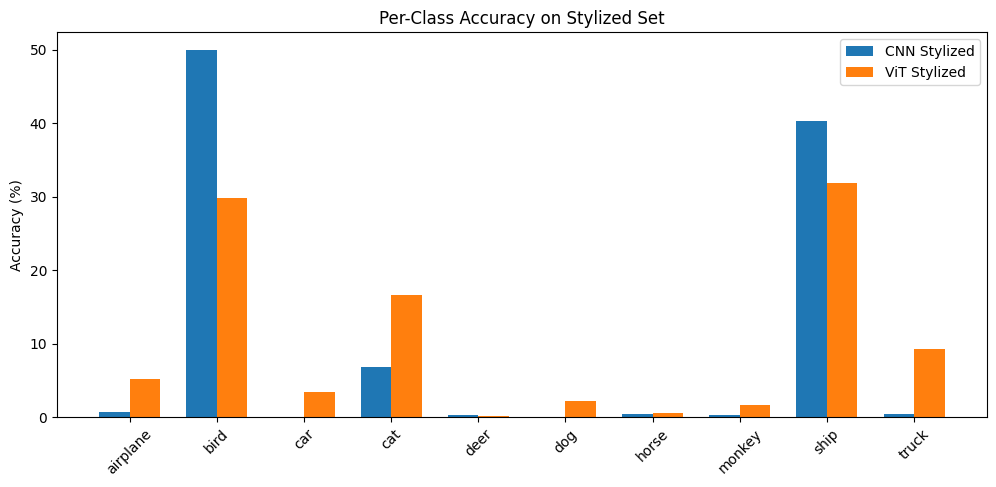

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Overall comparison
plt.figure(figsize=(6,4))
models = ["CNN", "ViT"]
orig_accs = [cnn_acc_orig, vit_acc_orig]
styl_accs = [cnn_acc_styl, vit_acc_styl]

x = np.arange(len(models))
w = 0.35
plt.bar(x - w/2, orig_accs, w, label="Original")
plt.bar(x + w/2, styl_accs, w, label="Stylized")

plt.xticks(x, models)
plt.ylabel("Accuracy (%)")
plt.title("Overall Accuracy: CNN vs ViT")
plt.legend()
plt.show()

# Per-class comparison
classes = test_dataset_raw.classes
x = np.arange(len(classes))

plt.figure(figsize=(12,5))
plt.bar(x - w/2, cnn_per_class_styl, w, label="CNN Stylized")
plt.bar(x + w/2, vit_per_class_styl, w, label="ViT Stylized")

plt.xticks(x, classes, rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy on Stylized Set")
plt.legend()
plt.show()

In [ ]:
import random

def predict_single(model, img, device, is_vit=False, processor=None):
    model.eval()
    with torch.no_grad():
        if is_vit:
            inputs = processor(images=[img], return_tensors="pt").pixel_values.to(device)
            outputs = model(inputs).logits
        else:
            tensor = cnn_transform(img).unsqueeze(0).to(device)
            outputs = model(tensor)
        _, pred = torch.max(outputs, 1)
    return pred.item()

# Pick 3 random indices
sample_indices = random.sample(range(len(test_dataset_raw)), 3)

plt.figure(figsize=(12,8))
for i, idx in enumerate(sample_indices):
    orig_img, label = test_dataset_raw[idx]

    # Load corresponding stylized image
    styl_img = Image.open(f"stylized_test/{idx}.png").convert("RGB")

    # Predictions
    cnn_pred_orig = predict_single(cnn_model, orig_img, device, is_vit=False)
    cnn_pred_styl = predict_single(cnn_model, styl_img, device, is_vit=False)
    vit_pred_orig = predict_single(vit_model, orig_img, device, is_vit=True, processor=vit_processor)
    vit_pred_styl = predict_single(vit_model, styl_img, device, is_vit=True, processor=vit_processor)

    # Plot
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(orig_img.permute(1,2,0))  # orig_img is tensor
    plt.axis("off")
    plt.title(f"Original (True: {test_dataset_raw.classes[label]})\n"
              f"CNN: {test_dataset_raw.classes[cnn_pred_orig]}, "
              f"ViT: {test_dataset_raw.classes[vit_pred_orig]}")

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(styl_img)
    plt.axis("off")
    plt.title(f"Stylized (True: {test_dataset_raw.classes[label]})\n"
              f"CNN: {test_dataset_raw.classes[cnn_pred_styl]}, "
              f"ViT: {test_dataset_raw.classes[vit_pred_styl]}")

plt.tight_layout()
plt.show()

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

<Figure size 1200x800 with 0 Axes>

In [22]:
from google.colab import files
import shutil

# Example: download stylized dataset at alpha=0.5
alpha = 0.5
folder_path = f"./stylized_test"

# Zip the folder
shutil.make_archive(f"./stylized_test", 'zip', folder_path)

# Download zip
files.download(f"./stylized_test.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
classes = ["airplane", "bird", "car", "cat", "deer",
           "dog", "horse", "monkey", "ship", "truck"]

class_map = {  # fixed mapping
    "airplane": "horse",
    "bird": "truck",
    "car": "cat",
    "cat": "ship",
    "deer": "dog",
    "dog": "airplane",
    "horse": "monkey",
    "monkey": "car",
    "ship": "deer",
    "truck": "bird"
}

In [ ]:
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# For generating images (before applying ResNet/ViT-specific processing)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load STL-10 test set (raw for PIL export)
stl10_test = STL10(root="./data", split="test", download=True, transform=basic_transform)

In [ ]:

import random

vgg.eval().to(device)
decoder.eval().to(device)

def sample_texture_image(target_class):
    """Pick a random image from the target class."""
    idxs = [i for i, (_, lbl) in enumerate(stl10_test) if classes[lbl] == target_class]
    rand_idx = random.choice(idxs)
    img, _ = stl10_test[rand_idx]
    return img.unsqueeze(0).to(device)

def create_cue_conflict(content_img, content_class):
    """Stylize one image using AdaIN."""
    target_class = class_map[content_class]
    texture_img = sample_texture_image(target_class)

    with torch.no_grad():
        c_feat = vgg(content_img.unsqueeze(0).to(device))
        s_feat = vgg(texture_img)
        t = adain(c_feat, s_feat)  # alpha=1.0
        output = decoder(t)
    return output.squeeze().cpu().clamp(0, 1)

def generate_stylized_dataset(output_dir="stylized_test"):
    os.makedirs(output_dir, exist_ok=True)
    for i, (img, label) in enumerate(stl10_test):
        content_class = classes[label]
        stylized_img = create_cue_conflict(img, content_class)
        pil_img = transforms.ToPILImage()(stylized_img)
        pil_img.save(f"{output_dir}/{i}_{content_class}.png")
        if i % 100 == 0:
            print(f"Processed {i}/{len(stl10_test)}")
    print("Stylized dataset created.")

In [ ]:
!rm -rf /content/2022-AdaIN-pytorch
!git clone --depth 1 https://github.com/media-comp/2022-AdaIN-pytorch.git /content/2022-AdaIN-pytorch
%cd /content/2022-AdaIN-pytorch

Cloning into '/content/2022-AdaIN-pytorch'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 61 (delta 4), reused 44 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 94.56 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (52/52), done.
/content/2022-AdaIN-pytorch


In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install numpy scikit-image pillow tqdm colorlog

In [ ]:
from Network import vgg19, decoder
encoder = vgg19().to(device)
encoder.load_state_dict(torch.load("vgg_normalized.pth", map_location=device))
encoder.eval()

decoder_net = decoder().to(device)
decoder_net.load_state_dict(torch.load("decoder.pth", map_location=device))
decoder_net.eval()
print("✅ Encoder & decoder loaded successfully")

✅ Encoder & decoder loaded successfully


In [ ]:
from torchvision.datasets import STL10

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# Load STL10 train split
stl_train = STL10(root="./data", split="train", download=True, transform=transform)

# Folder to save stylized images
outdir = "./stylized_stl10_media_comp"
os.makedirs(outdir, exist_ok=True)

# Build class → indices map for style sampling
stl10_classes = ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]
fixed_mapping = {"airplane":"ship","bird":"monkey","car":"truck","cat":"dog","deer":"horse",
                 "dog":"cat","horse":"deer","monkey":"bird","ship":"airplane","truck":"car"}
class_to_idx = {cls: i for i, cls in enumerate(stl10_classes)}
idx_mapping = {class_to_idx[c]: class_to_idx[s] for c, s in fixed_mapping.items()}

class_to_indices = {i: [] for i in range(10)}
for idx, (_, lab) in enumerate(stl_train):
    class_to_indices[lab].append(idx)

from utils import adaptive_instance_normalization

alpha = 0.1
for idx, (content_img, content_label) in enumerate(stl_train):
    style_label = idx_mapping[content_label]
    style_idx = random.choice(class_to_indices[style_label])
    style_img, _ = stl_train[style_idx]

    content = content_img.unsqueeze(0).to(device)
    style   = style_img.unsqueeze(0).to(device)

    with torch.no_grad():
        content_feats = encoder(content)
        style_feats   = encoder(style)
        t = adaptive_instance_normalization(content_feats, style_feats)
        output = decoder_net(alpha * t + (1-alpha) * content_feats)

    save_path = os.path.join(outdir, f"stylized_{idx}_c{content_label}_s{style_label}.png")
    save_image(output.clamp(0,1), save_path)


print("✅ Stylized dataset generated in", outdir)

100%|██████████| 2.64G/2.64G [00:47<00:00, 55.2MB/s]


✅ Stylized dataset generated in ./stylized_stl10_media_comp


In [ ]:
# Clean up old folders
!rm -rf ./stl10/orig ./stl10/stylized
os.makedirs("./stl10/orig", exist_ok=True)
os.makedirs("./stl10/stylized", exist_ok=True)

# Move original STL10 images (first 1000) to ./stl10/orig
for idx, (img, label) in enumerate(stl_train):
    if idx >= 1000:
        break
    # If transform was applied, img is already a tensor, so just save
    if isinstance(img, torch.Tensor):
        save_image(img, f"./stl10/orig/img_{idx}_c{label}.png")
    else:
        # If it's a PIL Image (no transform applied), convert to tensor
        save_image(transforms.ToTensor()(img), f"./stl10/orig/img_{idx}_c{label}.png")

# Move stylized images to ./stl10/stylized
for f in os.listdir(outdir):
    shutil.move(os.path.join(outdir, f), "./stl10/stylized/"+f)

# Quick check
print("Original images:", os.listdir("./stl10/orig")[:5])
print("Stylized images:", os.listdir("./stl10/stylized")[:5])


Original images: ['img_978_c7.png', 'img_775_c5.png', 'img_745_c7.png', 'img_736_c0.png', 'img_539_c9.png']
Stylized images: ['stylized_2076_c0_s8.png', 'stylized_4232_c7_s1.png', 'stylized_161_c2_s9.png', 'stylized_140_c9_s2.png', 'stylized_3125_c0_s8.png']


In [ ]:
class STL10StylizedDataset(Dataset):
    def __init__(self, orig_dir, stylized_dir, transform=None):
        self.orig_files = sorted(os.listdir(orig_dir))
        self.orig_dir = orig_dir
        self.stylized_dir = stylized_dir
        self.transform = transform

    def __len__(self):
        return len(self.orig_files)

    def __getitem__(self, idx):
        fname = self.orig_files[idx]
        orig_img = Image.open(os.path.join(self.orig_dir, fname)).convert("RGB")

        # Extract index
        idx_num = fname.split("_")[1]
        # Corresponding stylized image
        stylized_fname = [f for f in os.listdir(self.stylized_dir) if f.startswith(f"stylized_{idx_num}_")][0]
        stylized_img = Image.open(os.path.join(self.stylized_dir, stylized_fname)).convert("RGB")

        orig_label = int(fname.split("_c")[1].split(".")[0])
        texture_label = int(stylized_fname.split("_s")[1].split(".")[0])

        if self.transform:
            orig_img = self.transform(orig_img)
            stylized_img = self.transform(stylized_img)

        return orig_img, stylized_img, orig_label, texture_label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = STL10StylizedDataset(
    orig_dir="./stl10/orig",
    stylized_dir="./stl10/stylized",
    transform=transform
)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Quick check
for o, s, ol, tl in loader:
    print(o.shape, s.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
import torchvision
import torch.nn as nn

cnn_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 10)

vit_model = ViTForImageClassification.from_pretrained(
    "WinKawaks/vit-small-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)
processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

cnn_model.load_state_dict(torch.load(cnn_path, map_location=device))
cnn_model.to(device)

vit_model.load_state_dict(torch.load(vit_path, map_location=device))
vit_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
            (intermed

In [ ]:
results = []

cnn_model.eval()
vit_model.eval()

for orig_imgs, stylized_imgs, orig_labels, texture_labels in loader:
    orig_imgs = orig_imgs.to(device)
    stylized_imgs = stylized_imgs.to(device)

    # --- ResNet predictions ---
    with torch.no_grad():
        r_orig_preds = cnn_model(orig_imgs).argmax(dim=1).cpu().tolist()
        r_style_preds = cnn_model(stylized_imgs).argmax(dim=1).cpu().tolist()

    # --- ViT predictions (directly use normalized tensors) ---
    with torch.no_grad():
        v_orig_preds = vit_model(pixel_values=orig_imgs).logits.argmax(dim=1).cpu().tolist()
        v_style_preds = vit_model(pixel_values=stylized_imgs).logits.argmax(dim=1).cpu().tolist()

    # Append results
    for i in range(len(orig_imgs)):
        results.append({
            "orig_label": orig_labels[i],
            "texture_label": texture_labels[i],
            "resnet_orig": r_orig_preds[i],
            "resnet_stylized": r_style_preds[i],
            "vit_orig": v_orig_preds[i],
            "vit_stylized": v_style_preds[i]
        })

# Print first 10 results
for r in results[:10]:
    print(r)


{'orig_label': tensor(1), 'texture_label': tensor(7), 'resnet_orig': 1, 'resnet_stylized': 1, 'vit_orig': 1, 'vit_stylized': 8}
{'orig_label': tensor(2), 'texture_label': tensor(9), 'resnet_orig': 2, 'resnet_stylized': 8, 'vit_orig': 2, 'vit_stylized': 1}
{'orig_label': tensor(7), 'texture_label': tensor(1), 'resnet_orig': 7, 'resnet_stylized': 3, 'vit_orig': 7, 'vit_stylized': 9}
{'orig_label': tensor(1), 'texture_label': tensor(7), 'resnet_orig': 1, 'resnet_stylized': 8, 'vit_orig': 1, 'vit_stylized': 9}
{'orig_label': tensor(0), 'texture_label': tensor(8), 'resnet_orig': 0, 'resnet_stylized': 3, 'vit_orig': 0, 'vit_stylized': 5}
{'orig_label': tensor(0), 'texture_label': tensor(8), 'resnet_orig': 0, 'resnet_stylized': 8, 'vit_orig': 0, 'vit_stylized': 1}
{'orig_label': tensor(8), 'texture_label': tensor(0), 'resnet_orig': 8, 'resnet_stylized': 8, 'vit_orig': 8, 'vit_stylized': 9}
{'orig_label': tensor(0), 'texture_label': tensor(8), 'resnet_orig': 0, 'resnet_stylized': 3, 'vit_orig'

ResNet Accuracy (Original Images): 0.974
ResNet Accuracy (Stylized Images): 0.084
ResNet Avg Shape Bias: 0.084

ViT Accuracy (Original Images): 0.990
ViT Accuracy (Stylized Images): 0.067
ViT Avg Shape Bias: 0.067



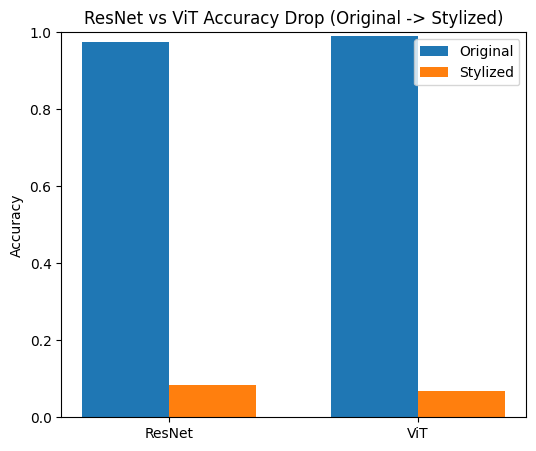

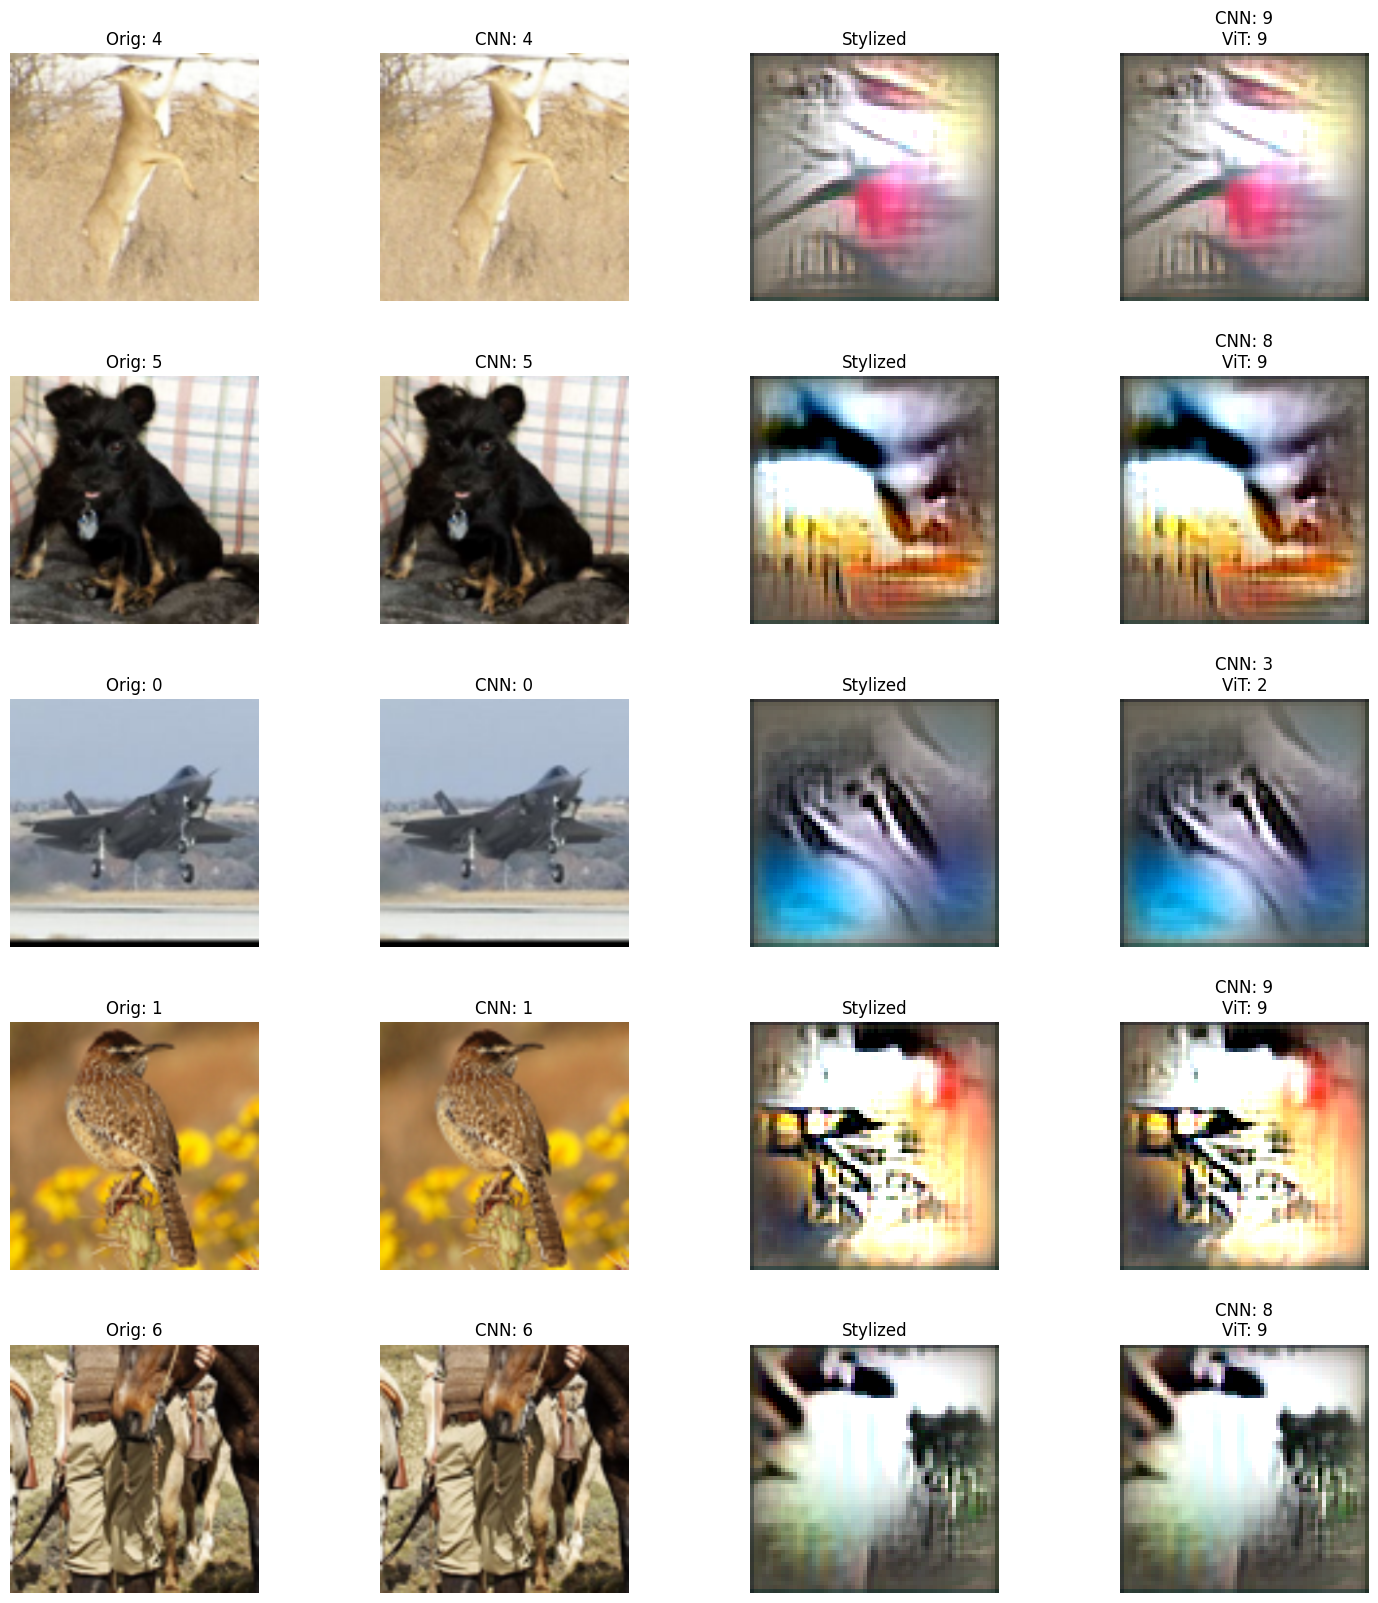

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Extract lists from results ---
orig_labels = np.array([r["orig_label"] for r in results])
texture_labels = np.array([r["texture_label"] for r in results])
r_orig_preds = np.array([r["resnet_orig"] for r in results])
r_style_preds = np.array([r["resnet_stylized"] for r in results])
v_orig_preds = np.array([r["vit_orig"] for r in results])
v_style_preds = np.array([r["vit_stylized"] for r in results])

# --- Accuracy function ---
def accuracy(preds, labels):
    return (preds == labels).mean()

# --- Shape bias function ---
# Shape bias = fraction of stylized images predicted as original class
def shape_bias(orig_labels, style_preds):
    return (orig_labels == style_preds).mean()

# --- Compute metrics ---
metrics = {
    "ResNet": {
        "orig_acc": accuracy(r_orig_preds, orig_labels),
        "stylized_acc": accuracy(r_style_preds, orig_labels),
        "shape_bias": shape_bias(orig_labels, r_style_preds)
    },
    "ViT": {
        "orig_acc": accuracy(v_orig_preds, orig_labels),
        "stylized_acc": accuracy(v_style_preds, orig_labels),
        "shape_bias": shape_bias(orig_labels, v_style_preds)
    }
}

# --- Print results ---
for model, m in metrics.items():
    print(f"{model} Accuracy (Original Images): {m['orig_acc']:.3f}")
    print(f"{model} Accuracy (Stylized Images): {m['stylized_acc']:.3f}")
    print(f"{model} Avg Shape Bias: {m['shape_bias']:.3f}\n")

# --- Visualize drop in accuracies ---
plt.figure(figsize=(6,5))
models = ["ResNet", "ViT"]
orig_accs = [metrics[m]["orig_acc"] for m in models]
stylized_accs = [metrics[m]["stylized_acc"] for m in models]
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, orig_accs, width, label="Original")
plt.bar(x + width/2, stylized_accs, width, label="Stylized")
plt.ylabel("Accuracy")
plt.title("ResNet vs ViT Accuracy Drop (Original -> Stylized)")
plt.xticks(x, models)
plt.ylim(0,1)
plt.legend()
plt.show()

# --- Visualize a few examples ---
import matplotlib.gridspec as gridspec

num_examples = 5
example_indices = np.random.choice(len(dataset), num_examples, replace=False)

plt.figure(figsize=(18, 4*num_examples))  # taller figure to fit images
gs = gridspec.GridSpec(num_examples, 4, wspace=0.3, hspace=0.3)  # control gaps

for i, idx in enumerate(example_indices):
    # Filenames
    orig_fname = dataset.orig_files[idx]
    idx_num = orig_fname.split("_")[1]
    stylized_fname = [f for f in os.listdir(dataset.stylized_dir) if f.startswith(f"stylized_{idx_num}_")][0]

    # Load images
    orig_img = Image.open(os.path.join(dataset.orig_dir, orig_fname))
    stylized_img = Image.open(os.path.join(dataset.stylized_dir, stylized_fname))

    # Predictions
    r_orig_pred = results[idx]["resnet_orig"]
    r_style_pred = results[idx]["resnet_stylized"]
    v_style_pred = results[idx]["vit_stylized"]
    orig_label = results[idx]["orig_label"]

    # --- Original image ---
    ax = plt.subplot(gs[i, 0])
    ax.imshow(orig_img)
    ax.axis("off")
    ax.set_title(f"Orig: {orig_label}", fontsize=12)

    # --- CNN prediction on original ---
    ax = plt.subplot(gs[i, 1])
    ax.imshow(orig_img)
    ax.axis("off")
    ax.set_title(f"CNN: {r_orig_pred}", fontsize=12)

    # --- Stylized image ---
    ax = plt.subplot(gs[i, 2])
    ax.imshow(stylized_img)
    ax.axis("off")
    ax.set_title("Stylized", fontsize=12)

    # --- CNN & ViT predictions on stylized ---
    ax = plt.subplot(gs[i, 3])
    ax.imshow(stylized_img)
    ax.axis("off")
    ax.set_title(f"CNN: {r_style_pred}\nViT: {v_style_pred}", fontsize=12)

plt.show()

# Experiment 3: Translational invariance test

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [ ]:
# For CNNs (ResNet) – match ImageNet training preprocessing
cnn_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # resize to 224x224
    transforms.ToTensor(),           # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # normalize
])

# For ViT – use HuggingFace processor
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def predict_resnet(img_pil):
    """Apply resnet preprocessing and forward pass."""
    x = cnn_transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = cnn_model(x)
    return torch.argmax(logits, dim=1).item()

def predict_vit(img_pil):
    """Apply vit preprocessing and forward pass."""
    inputs = vit_processor(images=img_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = vit_model(**inputs).logits
    return torch.argmax(logits, dim=1).item()

In [ ]:
from torchvision.transforms import functional as F

def translate_image(img_pil, dx, dy):
    """
    Shift PIL image by dx, dy pixels.
    Positive dx = right, positive dy = down.
    """
    return F.affine(img_pil, angle=0, translate=(dx, dy), scale=1.0, shear=0)


In [ ]:
stl10 = STL10(root="./data", split="test", download=True)

orig_images, shifted_images, labels = [], [], []

dx, dy = 5, 5  # translation offset

for i in range(len(stl10)):
    img, label = stl10[i]
    labels.append(label)
    orig_images.append(img)
    shifted_images.append(translate_image(img, dx, dy))

# ✅ NEW: keep a full copy of true labels (list of ints)
true_labels = [lbl for _, lbl in stl10]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, orig_images, shifted_images, labels, cnn_transform, vit_processor):
        self.orig_images = orig_images
        self.shifted_images = shifted_images
        self.labels = labels
        self.cnn_transform = cnn_transform
        self.vit_processor = vit_processor

    def __len__(self):
        return len(self.orig_images)

    def __getitem__(self, idx):
        orig = self.orig_images[idx]
        shifted = self.shifted_images[idx]
        label = self.labels[idx]

        # CNN tensors
        cnn_orig = self.cnn_transform(orig)
        cnn_shift = self.cnn_transform(shifted)

        # ViT tensors (batch dimension removed)
        vit_orig = self.vit_processor(images=orig, return_tensors="pt")["pixel_values"].squeeze(0)
        vit_shift = self.vit_processor(images=shifted, return_tensors="pt")["pixel_values"].squeeze(0)

        return cnn_orig, cnn_shift, vit_orig, vit_shift, label


# Build dataset + dataloader
dataset = TranslationDataset(orig_images, shifted_images, labels, cnn_transform, vit_processor)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
results = []

cnn_model.eval()
vit_model.eval()

with torch.no_grad():
    for cnn_o, cnn_s, vit_o, vit_s, y in loader:
        cnn_o, cnn_s = cnn_o.to(device), cnn_s.to(device)
        vit_o, vit_s = vit_o.to(device), vit_s.to(device)
        y = y.to(device)

        # CNN preds
        r_orig = cnn_model(cnn_o).argmax(dim=1).cpu()
        r_shift = cnn_model(cnn_s).argmax(dim=1).cpu()

        # ViT preds
        v_orig = vit_model(pixel_values=vit_o).logits.argmax(dim=1).cpu()
        v_shift = vit_model(pixel_values=vit_s).logits.argmax(dim=1).cpu()

        for i in range(len(y)):
            results.append({
                "label": y[i].item(),
                "resnet_orig": r_orig[i].item(),
                "resnet_shift": r_shift[i].item(),
                "vit_orig": v_orig[i].item(),
                "vit_shift": v_shift[i].item(),
            })

In [ ]:
import numpy as np

resnet_orig = np.array([r["resnet_orig"] for r in results])
resnet_shift = np.array([r["resnet_shift"] for r in results])
vit_orig = np.array([r["vit_orig"] for r in results])
vit_shift = np.array([r["vit_shift"] for r in results])
labels_np = np.array([r["label"] for r in results])

def accuracy(preds, labels):
    return (preds == labels).mean()

def consistency(orig, shifted):
    return (orig == shifted).mean()

# ResNet
r_acc_orig = accuracy(resnet_orig, labels_np)
r_acc_shift = accuracy(resnet_shift, labels_np)
r_consistency = consistency(resnet_orig, resnet_shift)

# ViT
v_acc_orig = accuracy(vit_orig, labels_np)
v_acc_shift = accuracy(vit_shift, labels_np)
v_consistency = consistency(vit_orig, vit_shift)

print(f"ResNet Accuracy (Original): {r_acc_orig:.3f}")
print(f"ResNet Accuracy (Shifted): {r_acc_shift:.3f}")
print(f"ResNet Consistency: {r_consistency:.3f}")
print()
print(f"ViT Accuracy (Original): {v_acc_orig:.3f}")
print(f"ViT Accuracy (Shifted): {v_acc_shift:.3f}")
print(f"ViT Consistency: {v_consistency:.3f}")


ResNet Accuracy (Original): 0.964
ResNet Accuracy (Shifted): 0.960
ResNet Consistency: 0.970

ViT Accuracy (Original): 0.984
ViT Accuracy (Shifted): 0.982
ViT Consistency: 0.986


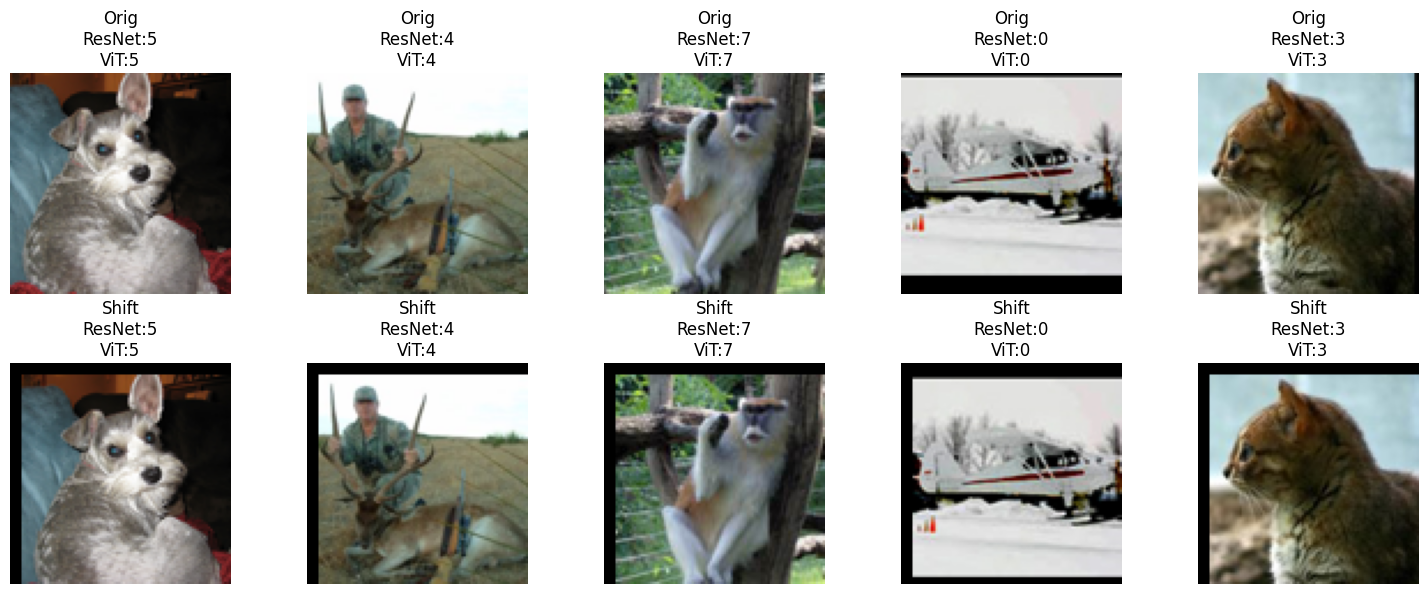

In [ ]:
import matplotlib.pyplot as plt

# Pick 5 random samples
idxs = np.random.choice(len(results), size=5, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(idxs):
    orig_img = orig_images[idx]
    shifted_img = shifted_images[idx]
    r = results[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(orig_img)
    plt.axis("off")
    plt.title(f"Orig\nResNet:{r['resnet_orig']}\nViT:{r['vit_orig']}")

    plt.subplot(2, 5, i+6)
    plt.imshow(shifted_img)
    plt.axis("off")
    plt.title(f"Shift\nResNet:{r['resnet_shift']}\nViT:{r['vit_shift']}")

plt.tight_layout()
plt.show()


In [ ]:
# ======================
# 5. Evaluation Loop
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device).eval()
vit_model.to(device).eval()

resnet_correct_orig = 0
resnet_correct_trans = 0
resnet_consistency = 0

vit_correct_orig = 0
vit_correct_trans = 0
vit_consistency = 0

n = len(dataset)

with torch.no_grad():
    for cnn_orig, cnn_shift, vit_orig, vit_shift, labels in loader:
        cnn_orig, cnn_shift = cnn_orig.to(device), cnn_shift.to(device)
        vit_orig, vit_shift = vit_orig.to(device), vit_shift.to(device)
        labels = labels.to(device)

        # CNN predictions
        logits_cnn_orig = cnn_model(cnn_orig)
        logits_cnn_shift = cnn_model(cnn_shift)
        preds_cnn_orig = logits_cnn_orig.argmax(dim=1)
        preds_cnn_shift = logits_cnn_shift.argmax(dim=1)

        resnet_correct_orig += (preds_cnn_orig == labels).sum().item()
        resnet_correct_trans += (preds_cnn_shift == labels).sum().item()
        resnet_consistency += (preds_cnn_orig == preds_cnn_shift).sum().item()

        # ViT predictions
        logits_vit_orig = vit_model(vit_orig).logits
        logits_vit_shift = vit_model(vit_shift).logits
        preds_vit_orig = logits_vit_orig.argmax(dim=1)
        preds_vit_shift = logits_vit_shift.argmax(dim=1)

        vit_correct_orig += (preds_vit_orig == labels).sum().item()
        vit_correct_trans += (preds_vit_shift == labels).sum().item()
        vit_consistency += (preds_vit_orig == preds_vit_shift).sum().item()

print("Evaluation done ✅")
print("ResNet Acc (Orig):", resnet_correct_orig/n)
print("ResNet Acc (Shift):", resnet_correct_trans/n)
print("ResNet Consistency:", resnet_consistency/n)
print("ViT Acc (Orig):", vit_correct_orig/n)
print("ViT Acc (Shift):", vit_correct_trans/n)
print("ViT Consistency:", vit_consistency/n)

Evaluation done ✅
ResNet Acc (Orig): 0.963625
ResNet Acc (Shift): 0.959875
ResNet Consistency: 0.9695
ViT Acc (Orig): 0.9835
ViT Acc (Shift): 0.982375
ViT Consistency: 0.985875


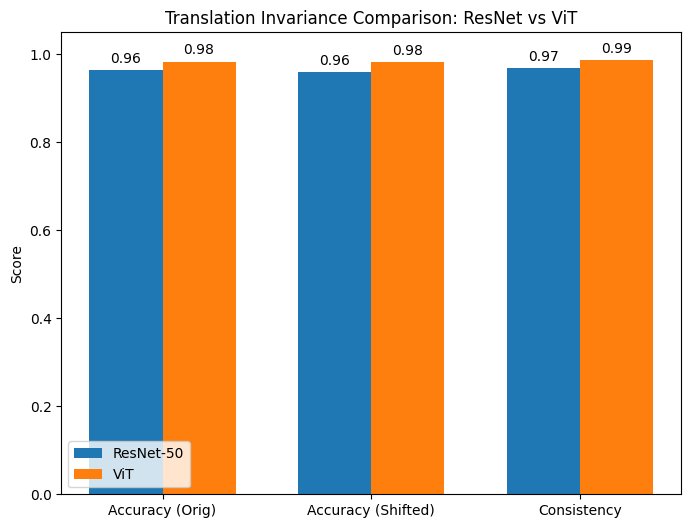

In [ ]:
import numpy as np

# ======================
# 6. Bar Plots
# ======================
labels = ["Accuracy (Orig)", "Accuracy (Shifted)", "Consistency"]

resnet_scores = [
    resnet_correct_orig/n,
    resnet_correct_trans/n,
    resnet_consistency/n
]

vit_scores = [
    vit_correct_orig/n,
    vit_correct_trans/n,
    vit_consistency/n
]

x = np.arange(len(labels))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, resnet_scores, width, label="ResNet-50")
rects2 = ax.bar(x + width/2, vit_scores, width, label="ViT")

# Add labels and formatting
ax.set_ylabel("Score")
ax.set_title("Translation Invariance Comparison: ResNet vs ViT")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha="center", va="bottom")

plt.show()

# Experiment 4: Permutation/Occlusion Test

In [ ]:
import numpy as np

def permute_patches(img_pil, patch_size=32):
    w, h = img_pil.size
    img_arr = np.array(img_pil)

    w_trim = (w // patch_size) * patch_size
    h_trim = (h // patch_size) * patch_size
    img_arr = img_arr[:h_trim, :w_trim, :]

    patches = []
    for i in range(0, h_trim, patch_size):
        for j in range(0, w_trim, patch_size):
            patches.append(img_arr[i:i+patch_size, j:j+patch_size, :])
    patches = np.array(patches)

    np.random.shuffle(patches)

    rows, idx = [], 0
    for i in range(0, h_trim, patch_size):
        row = []
        for j in range(0, w_trim, patch_size):
            row.append(patches[idx])
            idx += 1
        rows.append(np.concatenate(row, axis=1))

    permuted = np.concatenate(rows, axis=0)
    return Image.fromarray(permuted)

In [ ]:
def occlude_image(img_pil, occ_size=40):
    w, h = img_pil.size
    img_arr = np.array(img_pil).copy()

    x0 = (w - occ_size) // 2
    y0 = (h - occ_size) // 2
    img_arr[y0:y0+occ_size, x0:x0+occ_size, :] = 0

    return Image.fromarray(img_arr)


In [ ]:
perm_images, occ_images = [], []

for img in tqdm(orig_images, desc="Generating perturbed sets"):
    perm_images.append(permute_patches(img, patch_size=32))
    occ_images.append(occlude_image(img, occ_size=40))


Generating perturbed sets: 100%|██████████| 8000/8000 [00:02<00:00, 3184.41it/s]


In [ ]:
from torch.utils.data import Dataset, DataLoader

class PerturbationDataset(Dataset):
    def __init__(self, orig_images, perm_images, occ_images, labels, cnn_transform, vit_processor):
        self.orig_images = orig_images
        self.perm_images = perm_images
        self.occ_images = occ_images
        self.labels = labels
        self.cnn_transform = cnn_transform
        self.vit_processor = vit_processor

    def __len__(self):
        return len(self.orig_images)

    def __getitem__(self, idx):
        orig = self.orig_images[idx]
        perm = self.perm_images[idx]
        occ = self.occ_images[idx]
        label = self.labels[idx]

        # CNN
        cnn_orig = self.cnn_transform(orig)
        cnn_perm = self.cnn_transform(perm)
        cnn_occ = self.cnn_transform(occ)

        # ViT
        vit_orig = self.vit_processor(images=orig, return_tensors="pt")["pixel_values"].squeeze(0)
        vit_perm = self.vit_processor(images=perm, return_tensors="pt")["pixel_values"].squeeze(0)
        vit_occ = self.vit_processor(images=occ, return_tensors="pt")["pixel_values"].squeeze(0)

        return cnn_orig, cnn_perm, cnn_occ, vit_orig, vit_perm, vit_occ, label


dataset_permocc = PerturbationDataset(
    orig_images, perm_images, occ_images, labels,
    cnn_transform, vit_processor
)

# Keep num_workers=0 to avoid CUDA initialization errors
loader_permocc = DataLoader(dataset_permocc, batch_size=64, shuffle=False, num_workers=0)


In [ ]:
resnet_correct_orig = resnet_correct_perm = resnet_correct_occ = 0
vit_correct_orig = vit_correct_perm = vit_correct_occ = 0
n = len(dataset_permocc)

with torch.no_grad():
    for cnn_orig, cnn_perm, cnn_occ, vit_orig, vit_perm, vit_occ, labels in loader_permocc:
        cnn_orig, cnn_perm, cnn_occ = cnn_orig.to(device), cnn_perm.to(device), cnn_occ.to(device)
        vit_orig, vit_perm, vit_occ = vit_orig.to(device), vit_perm.to(device), vit_occ.to(device)
        labels = labels.to(device)

        # CNN
        resnet_correct_orig += (cnn_model(cnn_orig).argmax(1) == labels).sum().item()
        resnet_correct_perm += (cnn_model(cnn_perm).argmax(1) == labels).sum().item()
        resnet_correct_occ += (cnn_model(cnn_occ).argmax(1) == labels).sum().item()

        # ViT
        vit_correct_orig += (vit_model(vit_orig).logits.argmax(1) == labels).sum().item()
        vit_correct_perm += (vit_model(vit_perm).logits.argmax(1) == labels).sum().item()
        vit_correct_occ += (vit_model(vit_occ).logits.argmax(1) == labels).sum().item()

print("ResNet - Orig:", resnet_correct_orig/n, "Perm:", resnet_correct_perm/n, "Occ:", resnet_correct_occ/n)
print("ViT    - Orig:", vit_correct_orig/n, "Perm:", vit_correct_perm/n, "Occ:", vit_correct_occ/n)


ResNet - Orig: 0.95725 Perm: 0.861375 Occ: 0.85075
ViT    - Orig: 0.9835 Perm: 0.923875 Occ: 0.953625


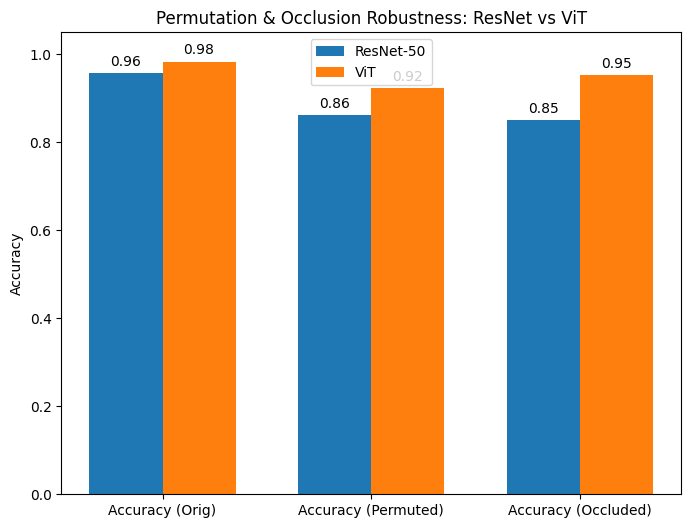

In [ ]:
import numpy as np

labels_bar = ["Accuracy (Orig)", "Accuracy (Permuted)", "Accuracy (Occluded)"]

resnet_scores = [
    resnet_correct_orig/n,
    resnet_correct_perm/n,
    resnet_correct_occ/n
]

vit_scores = [
    vit_correct_orig/n,
    vit_correct_perm/n,
    vit_correct_occ/n
]

x = np.arange(len(labels_bar))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, resnet_scores, width, label="ResNet-50")
rects2 = ax.bar(x + width/2, vit_scores, width, label="ViT")

ax.set_ylabel("Accuracy")
ax.set_title("Permutation & Occlusion Robustness: ResNet vs ViT")
ax.set_xticks(x)
ax.set_xticklabels(labels_bar)
ax.set_ylim(0, 1.05)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va="bottom")

plt.show()


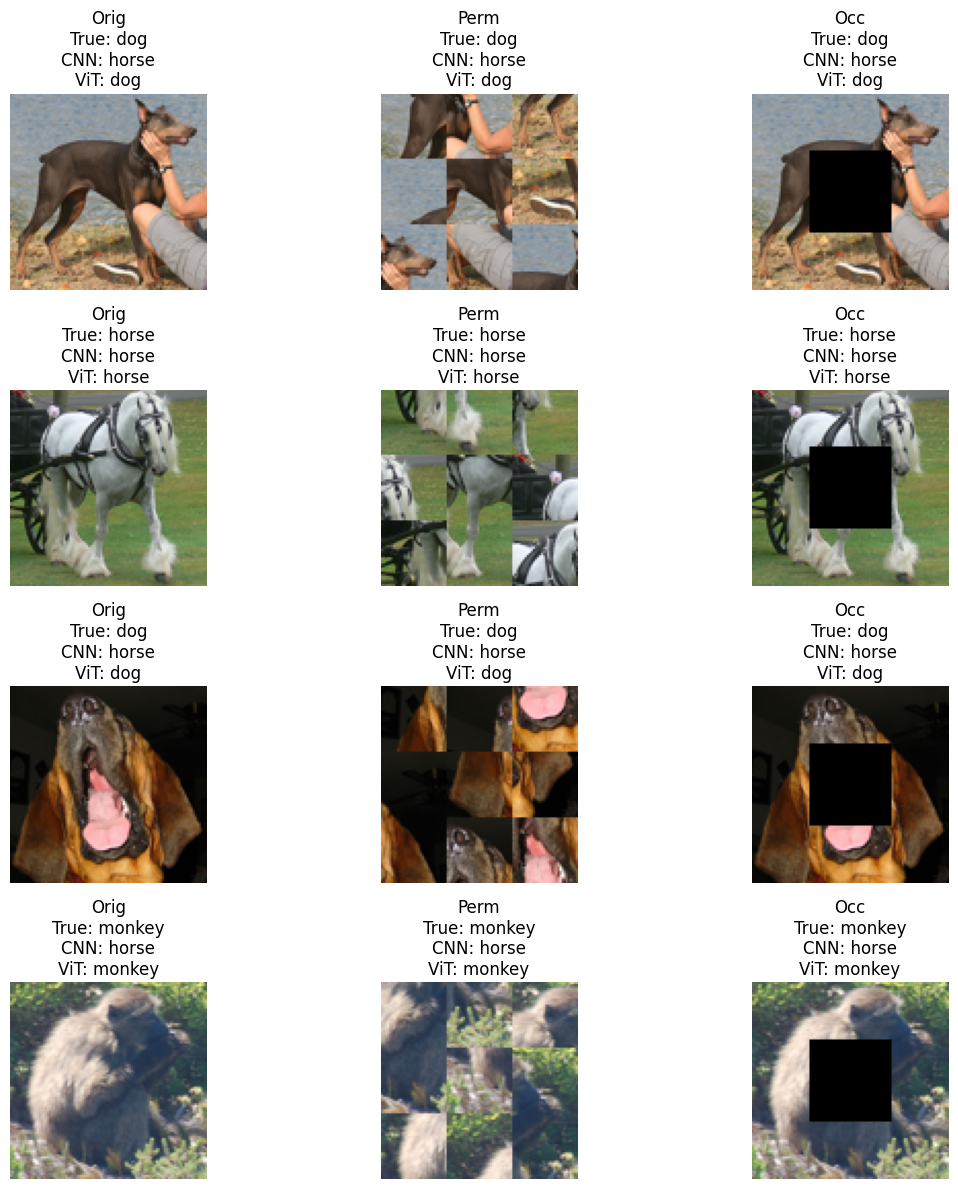

In [ ]:
import random
import matplotlib.pyplot as plt

# STL10 class names (from dataset docs)
stl10_classes = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# Pick a few random samples
idxs = random.sample(range(len(orig_images)), 4)

fig, axes = plt.subplots(len(idxs), 3, figsize=(12, 12))
for row, idx in enumerate(idxs):
    o, p, oc = orig_images[idx], perm_images[idx], occ_images[idx]
    true_label = true_labels[idx]
    true_class = stl10_classes[true_label]

    # CNN preds
    cnn_preds = [predict_resnet(x) for x in [o, p, oc]]
    # ViT preds
    vit_preds = [predict_vit(x) for x in [o, p, oc]]

    for col, (img, title) in enumerate(zip([o, p, oc], ["Orig", "Perm", "Occ"])):
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(
            f"{title}\nTrue: {true_class}\nCNN: {stl10_classes[cnn_preds[col]]}\nViT: {stl10_classes[vit_preds[col]]}"
        )

plt.tight_layout()
plt.show()


# Experiment 5: Feature Representation Analysis

In [ ]:
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTModel

# -----------------------
# ResNet Feature Extractor
# -----------------------
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # all layers except final FC
    def forward(self, x):
        x = self.features(x)  # (B, 2048, 1, 1)
        return torch.flatten(x, 1)  # (B, 2048)

resnet_extractor = ResNetFeatureExtractor(cnn_model).to(device)
resnet_extractor.eval()

# -----------------------
# ViT Feature Extractor
# -----------------------
# Use backbone (no classification head)
from transformers import ViTModel

vit_feat_extractor = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
vit_feat_extractor.eval()


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
# -----------------------
# Extract embeddings from subset
# -----------------------

subset_size = 200
idxs = torch.randperm(len(orig_images))[:subset_size]

resnet_feats, vit_feats, labels_subset = [], [], []

for i in idxs:
    img, label = orig_images[i], labels[i]
    labels_subset.append(label)

    # ----- ResNet features -----
    x_cnn = cnn_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_resnet = resnet_extractor(x_cnn)  # (1, 2048)
    resnet_feats.append(feat_resnet.cpu().numpy().squeeze())

    # ----- ViT features -----
    inputs = vit_processor(images=img, return_tensors="pt")["pixel_values"].to(device)
    with torch.no_grad():
        outputs = vit_feat_extractor(inputs)  # must be ViTModel, not vit_model
        feat_vit = outputs.pooler_output  # (1, 768)
    vit_feats.append(feat_vit.cpu().numpy().squeeze())

# Convert to numpy
resnet_feats = np.array(resnet_feats)
vit_feats = np.array(vit_feats)
labels_subset = np.array(labels_subset)


In [ ]:
# -----------------------
# Dimensionality reduction (t-SNE + PCA)
# -----------------------

# PCA
pca_resnet = PCA(n_components=2).fit_transform(resnet_feats)
pca_vit = PCA(n_components=2).fit_transform(vit_feats)

# t-SNE (slower but better clustering visualization)
tsne_resnet = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(resnet_feats)
tsne_vit = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(vit_feats)


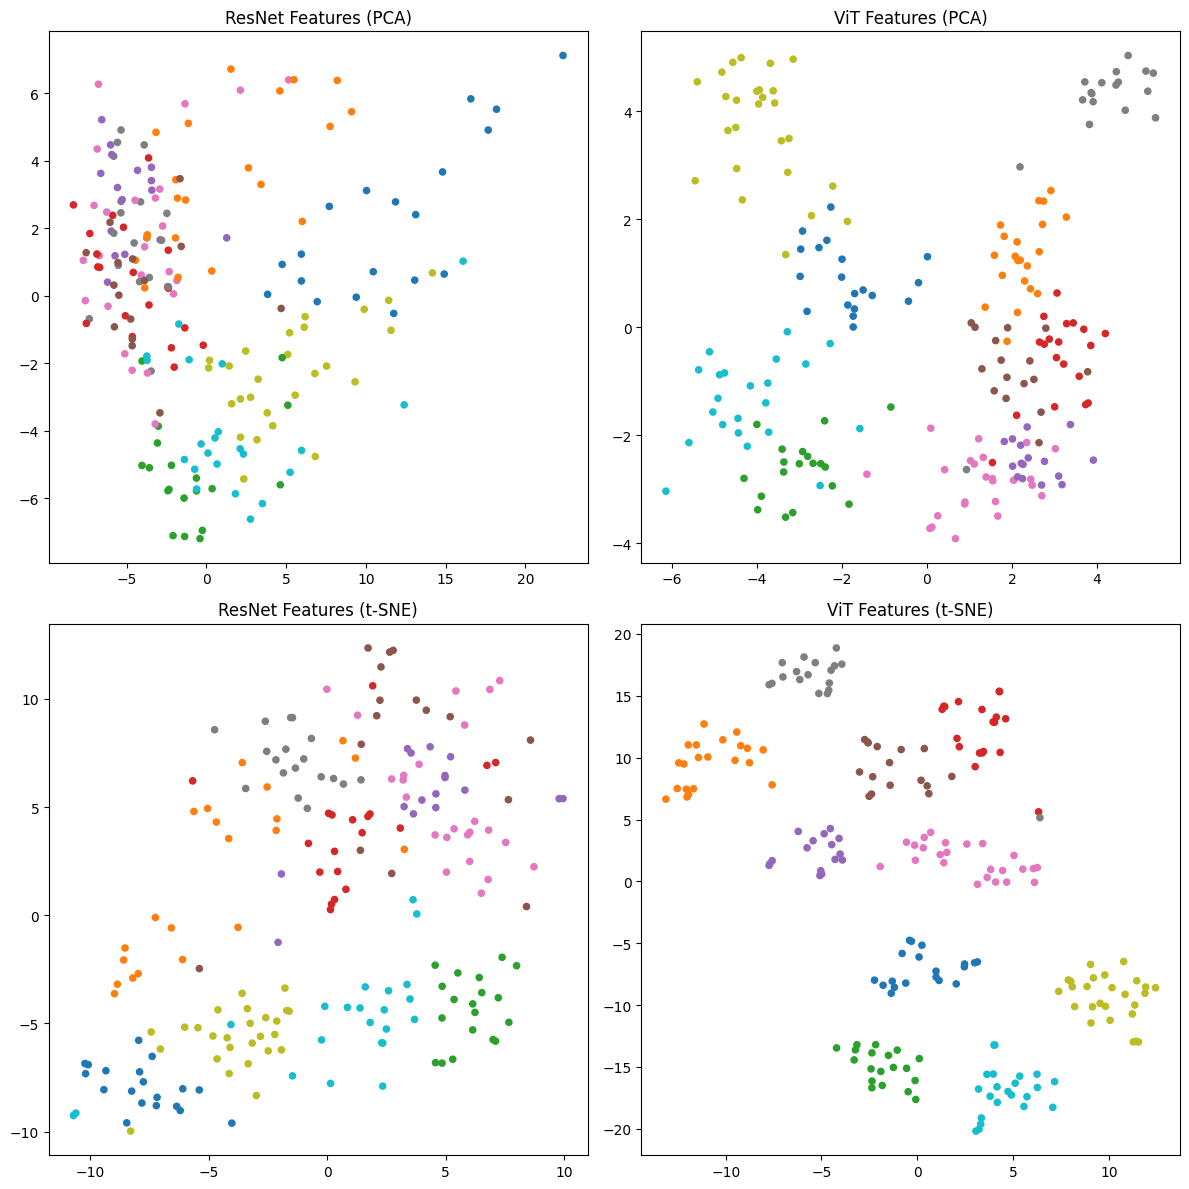

In [ ]:
# -----------------------
# Plot PCA vs t-SNE for ResNet and ViT
# -----------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# ResNet PCA
scatter = axes[0,0].scatter(pca_resnet[:,0], pca_resnet[:,1], c=labels_subset, cmap="tab10", s=20)
axes[0,0].set_title("ResNet Features (PCA)")

# ViT PCA
axes[0,1].scatter(pca_vit[:,0], pca_vit[:,1], c=labels_subset, cmap="tab10", s=20)
axes[0,1].set_title("ViT Features (PCA)")

# ResNet t-SNE
axes[1,0].scatter(tsne_resnet[:,0], tsne_resnet[:,1], c=labels_subset, cmap="tab10", s=20)
axes[1,0].set_title("ResNet Features (t-SNE)")

# ViT t-SNE
axes[1,1].scatter(tsne_vit[:,0], tsne_vit[:,1], c=labels_subset, cmap="tab10", s=20)
axes[1,1].set_title("ViT Features (t-SNE)")

plt.tight_layout()
plt.show()

# Experiment 6: Domain Generalization Test on PACs

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nickfratto/pacs-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pacs-dataset' dataset.
Path to dataset files: /kaggle/input/pacs-dataset


In [ ]:
import torch.nn as nn

# CNN (ResNet-50)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 7)

# ViT
from transformers import ViTForImageClassification
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=7,
    ignore_mismatched_sizes=True
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os

# Replace this with your actual dataset path
data_root = "/root/.cache/kagglehub/datasets/nickfratto/pacs-dataset/versions/2"

# Step 1: List top-level contents
top_level = os.listdir(data_root)
print("Top-level files/folders:", top_level)

# Step 2: Check if 'pacs_data' exists
pacs_data_path = os.path.join(data_root, "pacs_data")
if os.path.exists(pacs_data_path):
    print("\nFound 'pacs_data' folder. Domains inside:")
    domains = os.listdir(pacs_data_path)
    print(domains)
else:
    print("\nNo 'pacs_data' folder found, top-level contains:", top_level)
    domains = []

# Step 3: For each domain, list first 10 items
for d in domains:
    domain_path = os.path.join(pacs_data_path, d)
    if os.path.exists(domain_path):
        items = os.listdir(domain_path)
        print(f"\nDomain '{d}' has {len(items)} items. First 10:")
        print(items[:10])
    else:
        print(f"\nDomain '{d}' folder not found at expected path: {domain_path}")

# Step 4: If there are class subfolders, list them
for d in domains:
    domain_path = os.path.join(pacs_data_path, d)
    if os.path.exists(domain_path):
        class_subfolders = [f for f in os.listdir(domain_path) if os.path.isdir(os.path.join(domain_path, f))]
        print(f"\nDomain '{d}' has class subfolders: {class_subfolders}")


Top-level files/folders: ['pacs_data', 'pacs_label', 'dct2_images']

Found 'pacs_data' folder. Domains inside:
['pacs_data']

Domain 'pacs_data' has 4 items. First 10:
['art_painting', 'photo', 'sketch', 'cartoon']

Domain 'pacs_data' has class subfolders: ['art_painting', 'photo', 'sketch', 'cartoon']


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform for both CNN and ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

data_root = "/root/.cache/kagglehub/datasets/nickfratto/pacs-dataset/versions/2/pacs_data/pacs_data"

# Define domains
train_domains = ["photo", "art_painting", "cartoon"]
test_domain = "sketch"

# Train dataset: concatenate all training domains
train_data = torch.utils.data.ConcatDataset([
    datasets.ImageFolder(os.path.join(data_root, d), transform=transform)
    for d in train_domains
])

# Test dataset
test_data = datasets.ImageFolder(os.path.join(data_root, test_domain), transform=transform)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")


Train samples: 6062, Test samples: 3929


In [ ]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# ---------------------
# 1. Setup
# ---------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
vit_optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# Move models to device
cnn_model.to(device)
vit_model.to(device)

# Number of epochs
epochs = 3  # small number for demo; increase as needed


In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # --- key fix here ---
        outputs = model(imgs)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs  # ViT returns ImageClassifierOutput

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
def eval_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)  # <-- use model argument
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [ ]:
# ---------------------
# 4. Training loop (CNN)
# ---------------------
print("Training CNN on PACS...")
for epoch in range(epochs):
    loss, acc = train_epoch(cnn_model, train_loader, cnn_optimizer)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.4f}")

cnn_test_acc = eval_model(cnn_model, test_loader)
print(f"CNN Test Accuracy on {test_domain}: {cnn_test_acc:.4f}")


Training CNN on PACS...


100%|██████████| 95/95 [00:59<00:00,  1.61it/s]


Epoch 1/3 | Loss: 0.3563 | Train Acc: 0.8946


100%|██████████| 95/95 [00:57<00:00,  1.64it/s]


Epoch 2/3 | Loss: 0.0454 | Train Acc: 0.9875


100%|██████████| 95/95 [00:58<00:00,  1.63it/s]

Epoch 3/3 | Loss: 0.0179 | Train Acc: 0.9960


CNN Test Accuracy on sketch: 0.6903


In [ ]:
# ---------------------
# 5. Training loop (ViT)
# ---------------------
print("Training ViT on PACS...")
for epoch in range(epochs):
    loss, acc = train_epoch(vit_model, train_loader, vit_optimizer, criterion)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Train Acc: {acc:.4f}")

vit_test_acc = eval_model(vit_model, test_loader)
print(f"ViT Test Accuracy on {test_domain}: {vit_test_acc:.4f}")


Training ViT on PACS...
Epoch 1/3 | Loss: 0.0201 | Train Acc: 0.9944
Epoch 2/3 | Loss: 0.0048 | Train Acc: 0.9992
Epoch 3/3 | Loss: 0.0012 | Train Acc: 1.0000
ViT Test Accuracy on sketch: 0.7081


In [ ]:
# ---------------------
# 6. Compare
# ---------------------
print("=== Domain Generalization Results ===")
print(f"CNN Test Acc: {cnn_test_acc:.4f}")
print(f"ViT Test Acc: {vit_test_acc:.4f}")

=== Domain Generalization Results ===
CNN Test Acc: 0.6903
ViT Test Acc: 0.7081


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

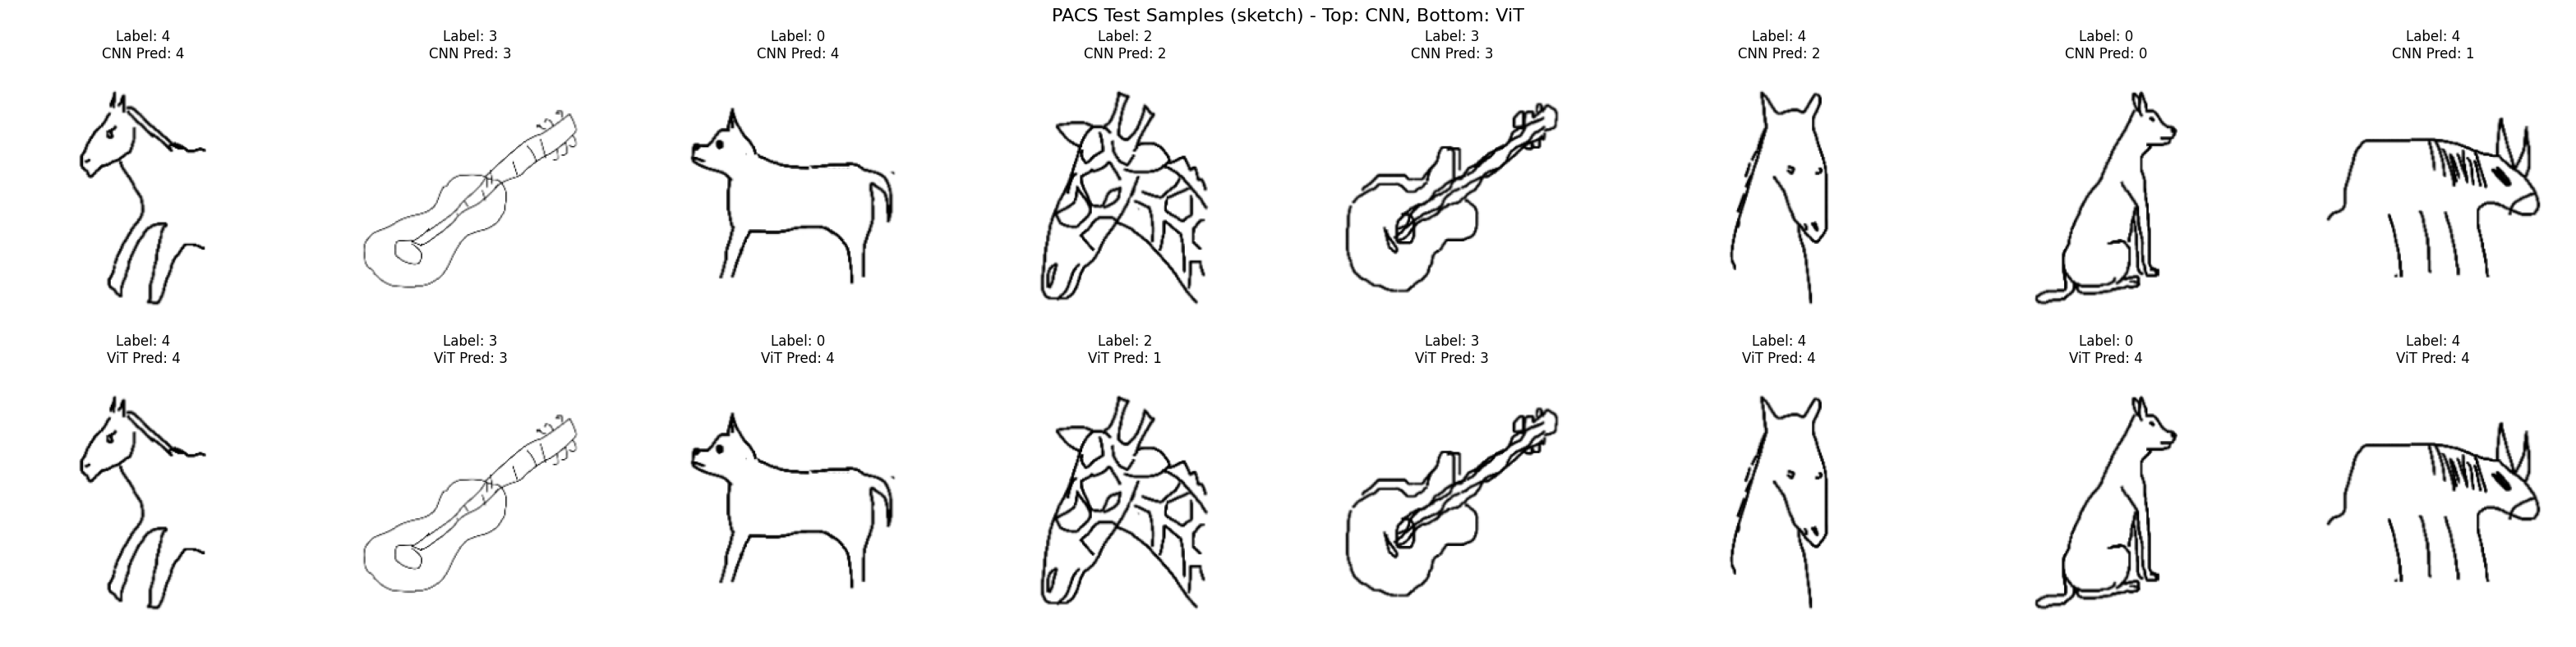

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
from torchvision import transforms
from transformers import AutoImageProcessor
import numpy as np

# -----------------------
# CNN Transform (for display only, prediction uses tensor directly)
# -----------------------
cnn_display_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],  # unnormalize
                         std=[1/0.229, 1/0.224, 1/0.225])
])

# -----------------------
# ViT Processor
# -----------------------
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# -----------------------
# Tensor-friendly prediction functions
# -----------------------
def predict_cnn_tensor(img_tensor):
    """Predict label with CNN (tensor input)."""
    cnn_model.eval()
    x = img_tensor.unsqueeze(0).to(device)  # add batch dim
    with torch.no_grad():
        logits = cnn_model(x)
    return torch.argmax(logits, dim=1).item()

def predict_vit_tensor(img_tensor):
    """Predict label with ViT (tensor input)."""
    vit_model.eval()
    # convert back to PIL internally since processor expects PIL
    from torchvision.transforms.functional import to_pil_image
    img_pil = to_pil_image((img_tensor + 1) / 2)  # unnormalize [-1,1] to [0,1]
    inputs = vit_processor(images=img_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = vit_model(**inputs)
        logits = outputs.logits
    return torch.argmax(logits, dim=1).item()

# ---------------------
# Pick a few test images
# ---------------------
num_samples = 8
idxs = random.sample(range(len(test_data)), num_samples)

fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))

for i, idx in enumerate(idxs):
    img_tensor, label = test_data[idx]  # tensor, not PIL

    # Unnormalize for display
    img_display = img_tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5  # from [-1,1] to [0,1]
    img_display = np.clip(img_display, 0, 1)

    # Predictions
    cnn_pred = predict_cnn_tensor(img_tensor)
    vit_pred = predict_vit_tensor(img_tensor)

    # Show original image and predictions
    axes[0, i].imshow(img_display)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Label: {label}\nCNN Pred: {cnn_pred}")

    axes[1, i].imshow(img_display)
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Label: {label}\nViT Pred: {vit_pred}")

plt.suptitle(f"PACS Test Samples ({test_domain}) - Top: CNN, Bottom: ViT", fontsize=16)
plt.tight_layout()
plt.show()


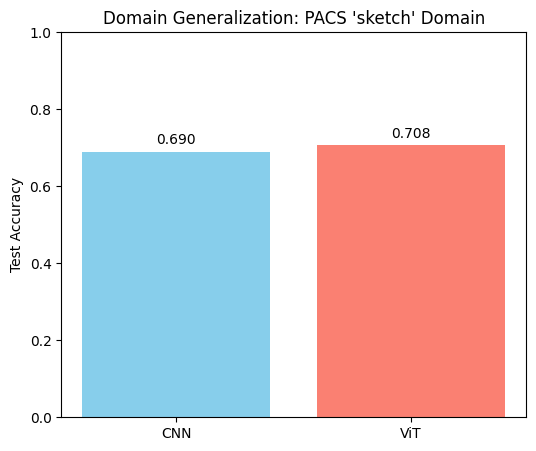

In [ ]:
# ---------------------
# 2. Bar plot comparison: CNN vs ViT on domain generalization
# ---------------------
models = ["CNN", "ViT"]
accuracies = [cnn_test_acc, vit_test_acc]

fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(models, accuracies, color=["skyblue", "salmon"])
ax.set_ylim(0, 1)
ax.set_ylabel("Test Accuracy")
ax.set_title(f"Domain Generalization: PACS '{test_domain}' Domain")

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:.3f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha="center", va="bottom")

plt.show()

In [1]:
!pip install pipreqs
!pipreqs /content --force

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=0ee7f5568ab58db7844d8294804f0b11b0a10900bc18a31d90115db080a4a54a
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in /content/requirements.txt
